Text Classification Using Logistic Regression


NetServe reviews

In [ ]:
Reference: https://github.com/Idilismiguzel/NLP-with-Python/blob/master/Text-Classification.ipynb


In [ ]:
## Importing Libraries

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

Inspecting Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Final_Dataset_V2.xlsx to Final_Dataset_V2.xlsx


In [ ]:
df = pd.read_excel('Final_Dataset_V2.xlsx')

In [ ]:
df.shape

(15000, 2)

In [ ]:
df.head()

,review,rating
0,Lost in Hartsfield I swear I hate ATL airport ...,1
1,Atlanta airport trash ðŸ˜«,1
2,"flight got fucking canceled, might have to spe...",1
3,"Disgusting. Took one bite, spit it out and th...",1
4,donâ€™t ever get lost in Atlanta airport the e...,1


In [ ]:
#df = pd.read_csv('sample_text_rating (1).csv')
df = pd.read_excel('Final_Dataset.xlsx')
df = df.dropna()

In [ ]:
df.shape

(8547, 2)

Data Cleansing


In [ ]:
# Deduplication Removing the dublicate rows
df.drop_duplicates(subset={'SENTENCE','rating'}, inplace=True)

In [ ]:
df.shape

(8505, 2)

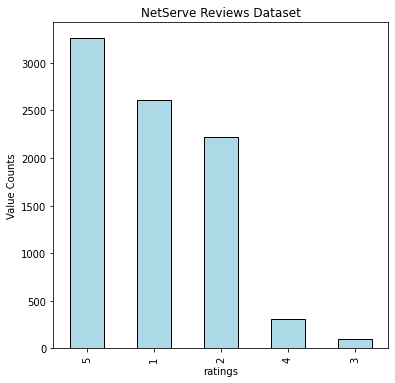

In [ ]:
ax = df['rating'].value_counts().plot(kind='bar', figsize=(6,6), fc="lightblue", ec="black");
fig = ax.get_figure()
ax.set_title("NetServe Reviews Dataset")
ax.set_xlabel('ratings')
ax.set_ylabel('Value Counts');


Dataset has 5-star rating system and ratings are highly unbalanced. Due to high 
number of 5-star rating, I have decided to *label* score 4 and 5 as positive and else negative

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df['SENTENCE'].dtype

dtype('O')

In [ ]:
df.describe()

,rating
count,8505.000000
mean,2.930159
std,1.747479
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,5.000000


In [ ]:
df['Label'] = 0
df.loc[df['rating'] > 3, ['Label']] = 1

In [ ]:
len(df[df['Label'] == 1])/len(df)

0.4205761316872428

~79% of the overall reviews from the sample data set is positive reviews

Text Pre-Processing

In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
text= df['SENTENCE']
text

0       parking is easy and the parking fee is reasonable
1                        this is one of the best aquarium
2                       i was blown away by the exhibits.
3                                  everything was so cool
4                                 definitely worth seeing
                              ...                        
8542                   It was run down and uncomfortable.
8543    The staff are polite but clearly exhausted and...
8544    I haven't been in 20yrs and I was NOT impresse...
8545    It was nice but reminded me of why I don't go ...
8546    This new season pass policy that includes blac...
Name: SENTENCE, Length: 8505, dtype: object

In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
df['Text_Cleaned'] = list(map(clean_text, df.SENTENCE))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df.Text_Cleaned))

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatized_words(df.Text_Cleaned)

In [ ]:
df.head(20)

,SENTENCE,rating,Label,Text_Cleaned,lemmatized_text
0,parking is easy and the parking fee is reasonable,5,1,"[parking, easy, parking, fee, reasonable]","[parking, easy, parking, fee, reasonable]"
1,this is one of the best aquarium,5,1,"[one, best, aquarium]","[one, best, aquarium]"
2,i was blown away by the exhibits.,5,1,"[blown, away, exhibits]","[blown, away, exhibit]"
3,everything was so cool,4,1,"[everything, cool]","[everything, cool]"
4,definitely worth seeing,4,1,"[definitely, worth, seeing]","[definitely, worth, seeing]"
5,we spent many hours to watch the marine life a...,5,1,"[spent, many, hours, watch, marine, life, inte...","[spent, many, hour, watch, marine, life, inter..."
6,it is very nice,5,1,[nice],[nice]
7,i will visit again.,4,1,[visit],[visit]
8,it is an awesome site.,5,1,"[awesome, site]","[awesome, site]"
9,it is a great family outing,5,1,"[great, family, outing]","[great, family, outing]"


In [ ]:
pd.set_option('max_colwidth', 500)
df[['rating', 'SENTENCE', 'Label', 'Text_Cleaned', 'lemmatized_text']].sample(3)

,rating,SENTENCE,Label,Text_Cleaned,lemmatized_text
2118,5,the volunteers were super knowledgeable and very friendly.,1,"[volunteers, super, knowledgeable, friendly]","[volunteer, super, knowledgeable, friendly]"
4233,5,one of my favorite games of the year,1,"[one, favorite, games, year]","[one, favorite, game, year]"
3137,5,the variety of animals is amazing.,1,"[variety, animals, amazing]","[variety, animal, amazing]"


In [ ]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(df['Text_Cleaned'])

words = bow_converter.get_feature_names()
len(words)

5446

In [ ]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(df['Text_Cleaned'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

25779

In [ ]:
bigrams[-10:]

['\uf8ff üòç',
 '\uf8ff üòé',
 '\uf8ff üòí',
 '\uf8ff üòî',
 '\uf8ff üòò',
 '\uf8ff üòú',
 '\uf8ff üòû',
 '\uf8ff üòü',
 '\uf8ff üôè',
 '\uf8ff üôñ']

In [ ]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(df['Text_Cleaned'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

In [ ]:
trigrams[:10]

['0 adult 15',
 '0 one respects',
 '0 stars rides',
 '0 would would',
 '00 9 30',
 '00 close restrooms',
 '00 parking 35',
 '00 tsa checkpoint',
 '000 fish many',
 '00pm plan eat']

In [ ]:
print(len(words), len(bigrams), len(trigrams))

2008 7314 6772


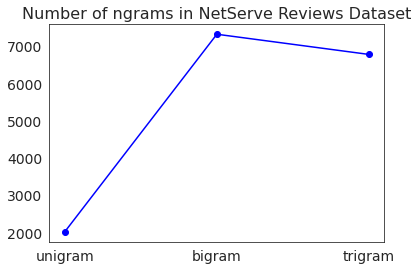

In [ ]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams in NetServe Reviews Dataset', {'fontsize':16})
plt.show()

Bag of Words Transformation

In [ ]:
training_data, test_data = sklearn.model_selection.train_test_split(df, train_size = 0.7, random_state=42)

In [ ]:
print(training_data.shape)
print(test_data.shape)

(3184, 5)
(1365, 5)


In [ ]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)

In [ ]:
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned'])

In [ ]:
len(bow_transform.vocabulary_)

4958

In [ ]:
X_tr_bow.shape

(3184, 4958)

In [ ]:
X_te_bow = bow_transform.transform(test_data['Text_Cleaned'])

In [ ]:
y_tr = training_data['Label']
y_te = test_data['Label']

Tf-Idf Tranformation

In [ ]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

AttributeError: ignored

In [ ]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

Classification with Logistic Regression

In [ ]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [ ]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.8014652014652015
Test Score with tf-idf features 0.810989010989011


In [ ]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [ ]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
bow_search.best_score_

0.7955397253240919

In [ ]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
tfidf_search.best_score_

0.7961676688091783

In [ ]:
bow_search.best_params_

{'C': 100.0}

In [ ]:
bow_search.cv_results_

{'mean_fit_time': array([0.04915299, 0.05825539, 0.07349687, 0.04358187, 0.08692479,
        0.11198797]),
 'std_fit_time': array([0.03221595, 0.01455383, 0.0291064 , 0.00952284, 0.00734933,
        0.00258223]),
 'mean_score_time': array([0.0024745 , 0.00104537, 0.00099092, 0.00071115, 0.00056553,
        0.00056515]),
 'std_score_time': array([3.02304657e-03, 1.64987559e-04, 1.12768651e-04, 1.75480117e-04,
        4.86271043e-05, 7.31014225e-05]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.78178964, 0.78178964, 0.78178964, 0.7833595 , 0.79277865,
        0.79120879]),
 'split1_test_score': array([0.78178964, 0.78178964, 0.78178964, 0.78021978, 0.78963893,
        0.79434851]),
 'split2_test_score': array([0.7817896

In [ ]:
results_file = open('tfidf_gridcv_results.pkl', 'wb')
pickle.dump(bow_search, results_file, -1)
pickle.dump(tfidf_search, results_file, -1)
results_file.close()

In [ ]:
pkl_file = open('tfidf_gridcv_results.pkl', 'rb')
bow_search = pickle.load(pkl_file)
tfidf_search = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf
0,0.781721,0.781721
1,0.781721,0.781721
2,0.781721,0.793028
3,0.783605,0.795540
4,0.793656,0.796168
5,0.795540,0.796168


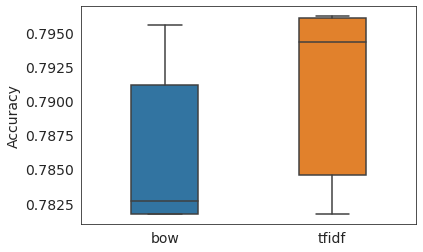

In [ ]:
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')

In [ ]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test Score with bow features 0.8117216117216117
Test Score with tf-idf features 0.8117216117216117
